In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from scipy import interp
from scipy.sparse import hstack, csr_matrix

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

# CTRL + SHIFT + P => Run Code 
import sys
print('Python', sys.version)
print(sklearn.__version__)

Python 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
0.20.3


### Results Collection

In [2]:
global ResultsCollection 
ResultsCollection = pd.DataFrame(columns=('Algorithm', 'FeatureSet', 'TestAcc', 'TestAUC'))

global testSize
testSize = 0.25

# Create Folder to save too

from datetime import datetime
import os

date = datetime.now().strftime("%Y%m%d-%H%M%S")

global path
path = "D:\\0_MyFiles\\0_Libraries\\Documents\\Education\\University\\Year 3\\FYP_Git\\ROC Curves\\"

import os
if not os.path.exists(path):
    os.makedirs(path)

# Feature Set List

In [3]:
# Switch for multiple feautre sets
def getFeatureSet(number):
    return {
        1 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 'bot'],
        2 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count_binary', 'verified', 
             'name_binary','description_binary', 'screen_name_binary','bot'],
        3 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 
             'name_binary','description_binarySTEM', 'screen_name_binary','bot'],        
        99 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 
              'name', 'screen_name', 'description', 'bot'],
    }[number]

# Import Training Data

In [4]:
# Read training data from csv
training_data = pd.read_csv('training_data.csv')
t2 = pd.read_csv('genuine_accounts_users.csv')
t3 = pd.read_csv('fake_followers_users.csv')
training_data['description'].fillna(' ', inplace=True)

features = getFeatureSet(99)

t2['bot'] = 0
t3['bot'] = 1

t2 = t2[features]
t3 = t3[features]
training_data = training_data[features]

new_data = t2.append(t3, ignore_index=True)
training_data = new_data.append(training_data, ignore_index=True)

training_data = training_data.sample(frac=1).reset_index(drop=True)
training_data['description'].fillna(' ', inplace=True)
training_data['verified'].fillna('0', inplace=True)

# Feature Development

### Stemming applied to description

In [5]:
def getTextDesc(desc):
    try:
        if isinstance(desc, float):
            return ''
        return desc
    except Exception as error:
        return ''
    
training_data['description'] = training_data.apply(lambda row: getTextDesc(row['description']), axis=1)

def stemLine(sentence):
    stemmer = nltk.PorterStemmer()
    translator=sentence.translate(str.maketrans("","", string.punctuation))
    translator = translator.lower()
    tokens = word_tokenize(translator)
    final = [stemmer.stem(tagged_word) for tagged_word in tokens]
    return " ".join(final)

training_data['descriptionStemmed'] = training_data['description'].apply(lambda row: stemLine(row))

### Binary True/False Conditions

In [6]:
#Binary
name_keywords = r'bot|b0t|papers'
stemmedKeywords = r'bot|b0t|random|#botally|creat|thi|time|//|botal|pubm|made|im|gener|day|everi|paper|follow|tweet|word'
keywords = r'bot|b0t|papers|#botally|follow|every|made|//|random|day|daily|tweet|tweets|made'

training_data['name_binary'] = training_data.name.str.contains(keywords, case=False, na=False)
training_data['screen_name_binary'] = training_data.screen_name.str.contains(keywords, case=False, na=False)

training_data['description_binarySTEM'] = training_data.description.str.contains(stemmedKeywords, case=False, na=False)

training_data['description_binary'] = training_data.description.str.contains(keywords, case=False, na=False)
#training_data['status_binary'] = training_data.status.str.contains(keywords, case=False, na=False)

training_data['listed_count_binary'] = (training_data.listed_count>20000)==False

# Global Classifier Functions

In [7]:
# Using Features create the test and traing X and Y
def initiateXY(features):
    # set X to all data fields and Y to bot field
    x = training_data[features].iloc[:, :-1] # x is all data
    y = training_data[features].iloc[:, -1] # y is bot bool
    return x, y

# Classifiers

### Naive Bayes

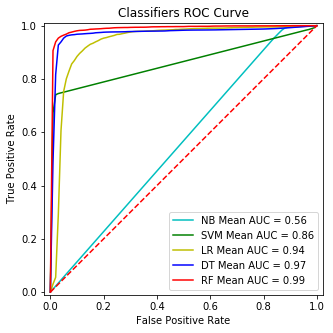

In [8]:
    features = getFeatureSet(3)
    x, y = initiateXY(features)
    
    nb = MultinomialNB(alpha=0.00000000001)
    lr = LogisticRegression(random_state=10, solver='lbfgs',multi_class='multinomial', C=0.00001)
    sv = svm.SVC(gamma='auto', probability=True, C=10)
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10)
    rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000)

    kf = KFold(n_splits=10)

    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    plt.figure(figsize=(5, 5))

    #NB --------------------------
    
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = nb.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
            
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_tprs[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tprs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, 'c', label=r'NB Mean AUC = %0.2f' % (mean_auc))
    
    #SVM --------------------------
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = sv.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
            
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_tprs[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tprs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, 'g', label=r'SVM Mean AUC = %0.2f' % (mean_auc))
    
    #LR --------------------------
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = lr.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
            
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_tprs[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tprs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, 'y', label=r'LR Mean AUC = %0.2f' % (mean_auc))
    
    
    #DT --------------------------
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = dt.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
            
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_tprs[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tprs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, 'b', label=r'DT Mean AUC = %0.2f' % (mean_auc))
    
    #RF --------------------------
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = rf.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
            
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_tprs[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tprs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, 'r', label=r'RF Mean AUC = %0.2f' % (mean_auc))

    #PLOT ------------------------
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.title("Classifiers ROC Curve")
    plt.legend(loc = 'lower right')
    plt.savefig(path + str(date) + " Classifiers ROC Curve" + '.png')
    plt.show()